Button(description='Generate data', style=ButtonStyle())

[[215, 233], [218, 172], [100, 246], [100, 189], [187, 118], [105, 235], [187, 128], [153, 178], [168, 169], [207, 198], [100, 203], [215, 246], [182, 120], [230, 129], [144, 197], [169, 250], [246, 107], [181, 155], [141, 146], [183, 243], [152, 116], [187, 107], [219, 102], [103, 205], [195, 157], [240, 102], [162, 125], [202, 169], [200, 156], [223, 215], [108, 238], [207, 134], [105, 103], [170, 110], [126, 124], [156, 156], [222, 120], [246, 121], [162, 246], [249, 154], [206, 200], [162, 228], [221, 100], [131, 148], [184, 162], [162, 203], [249, 228], [120, 204], [232, 130], [136, 183], [236, 211], [240, 107], [239, 178], [196, 149], [174, 235], [206, 105], [168, 219], [167, 117], [188, 112], [183, 241], [219, 163], [218, 178], [211, 249], [122, 215], [166, 137], [206, 130], [246, 198], [211, 138], [181, 168], [114, 152], [215, 105], [126, 199], [109, 210], [245, 124], [194, 211], [159, 239], [168, 245], [231, 185], [241, 240], [170, 159], [225, 102], [158, 109], [111, 171], [13

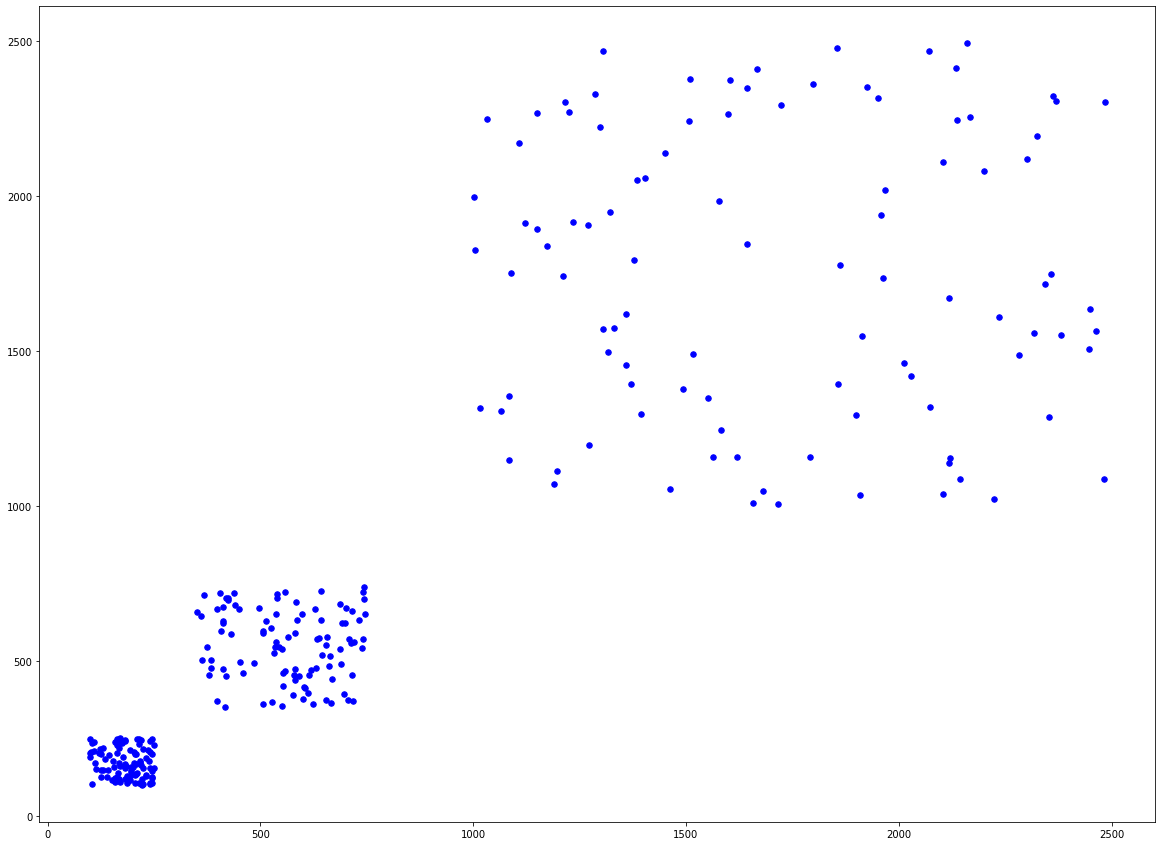

In [18]:
import requests
import os
from IPython.display import display
from ipywidgets import widgets
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

generate_data_button = widgets.Button(description="Generate data")

generated_data = []
cluster_num = 3
bounds = [[100, 250],[100, 250],[350, 750],[350, 750],[1000, 2500],[1000, 2500]]

def get_host():
    host = os.getenv("ENV_KMEANS_BACKEND_HOST")
    if not host:
        host = "localhost"
    return host

def get_port():
    port = os.getenv("ENV_KMEANS_BACKEND_PORT")
    if not port:
        port = 11111
    return port


def generate_data(b):
    global generated_data
    host = get_host()
    port = get_port()
    url = 'http://{}:{}/generatedata'.format(host, port)
    headers = {'Content-Type':'application/json'}
    body = {'clusterNum': cluster_num,'bounds': bounds}
    response = requests.post(url, json=body, headers=headers)
    generated_data = response.json()['data']
    show_generated_data(generated_data)

def cluster_data():
    pass


def show_generated_data(generated_data):
    df = pd.DataFrame(generated_data, columns =['x', 'y'], dtype = int)
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111)
    ax.scatter(x=df["x"],
               y=df["y"],
               s=30,
               c='b',
               label='Generated data')

display(generate_data_button)

generate_data_button.on_click(generate_data)
